# Gradient Boosting Decision Trees

The “Gradient Boosting” method and term originate in:\
“Greedy Function Approximation: A Gradient Boosting Machine” by Jerome H. Friedman, \
The Annals of Statistics http://www.jstor.org/stable/2699986.

## Model and Parameters

This section of the tutroal is based on:\
https://xgboost.readthedocs.io/en/stable/tutorials/model.html

The **model** in supervised learning refers to a mathematical structure by which the prediction $y_i$ is made from the input $x_i$ ($i$ is an instance, a sample). A common example is a linear model, where the prediction is given as $\hat{y}_i = \sum_j \theta_j x_{ij}$, a linear combination of weighted ($\theta$) input features. The prediction value can have different interpretations, depending on the task, i.e., regression or classification. For example, it can be logistic transformed to get the probability of positive class.

The **parameters** are the undetermined part that we need to learn from data. For example, in linear regression problems, the parameters are the coefficients $\theta$.

## Objective Function

The task of training the model amounts to finding the parameters $\theta$ that best fit the training data $x_i$ and $y_i$. In order to train the model, we need to define the **objective function** to measure how well the model fit the training data. A characteristic of objective functions is that they consist of two parts: training loss and regularization term:
$$\text{obj}(\theta) = L(\theta) + \Omega(\theta)$$
The **training loss** $L$ measures how predictive our model is with respect to the training data.\
The **regularization term** $\Omega$ controls the complexity of the model, which helps us to avoid overfitting.

The general principle is we want both a simple and predictive model.

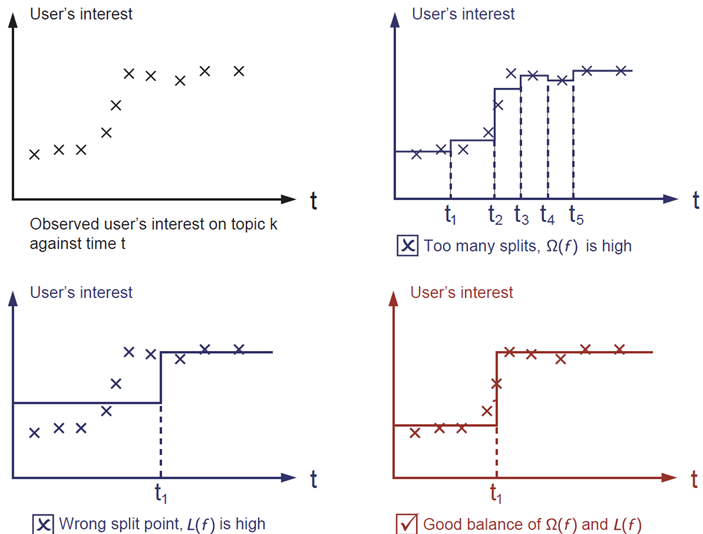

## Decision Tree Ensembles

The **tree ensemble** model consists of a set of classification and regression trees. Below is a simple example of a tree that classifies whether someone will like a hypothetical computer game X. We classify the members of a family into different leaves, and assign them the score on the corresponding leaf.

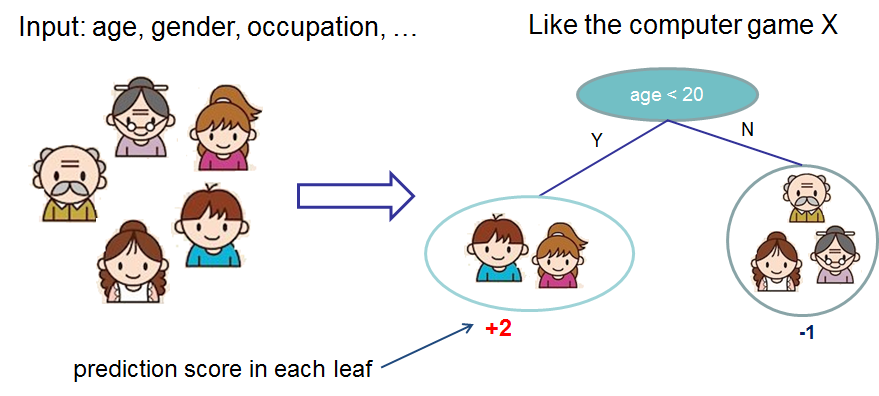

Below is an example of an ensemble of two trees. The prediction scores of each individual tree are summed up to get the final score. If you look at the example, an important fact is that the two trees try to complement each other. Usually, a single tree is not strong enough to be used in practice. The ensemble model sums the prediction of multiple trees together.

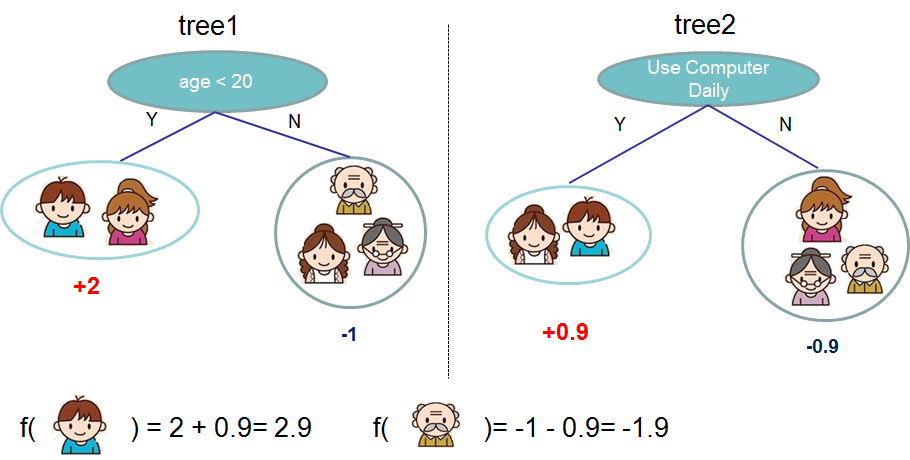

We need to learn the structure of the tree and the leaf scores. Learning tree structure is much harder than traditional optimization problem where you can simply take the gradient. It is intractable to learn all the trees at once. Instead, we use an additive strategy: fix what we have learned, and add one new tree at a time. Ideally we would enumerate all possible trees and pick the best one. In practice this is intractable, so we will try to optimize one level of the tree at a time.

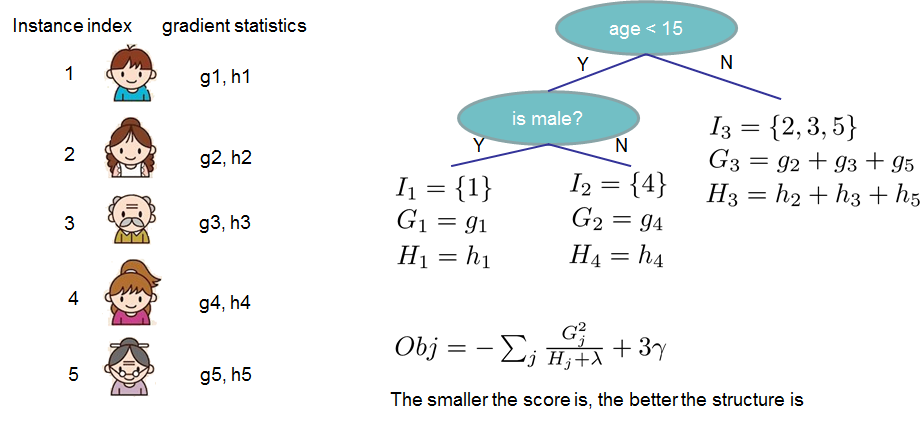

We want to search for an optimal split in a given feature. To efficiently do so, we place all the instances in sorted order by the feature values, like the following picture. A left to right scan is sufficient to calculate the score of all possible split solutions, and we can find the best split efficiently.

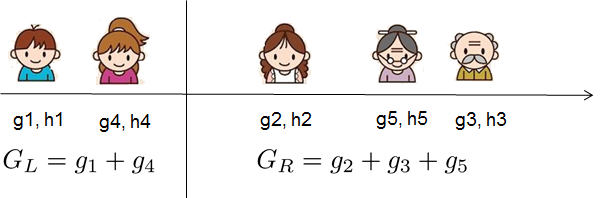

**Hyperparameters**, like the learning rate that controls the step size during optimization and the maximum tree depth that influences the complexity of individual trees, significantly influence the performance and behavior of the model. We will explore this in a later section of this tutorial.

There are two main types of tree ensemble:

**Random Forests** builds an ensemble of Decision Trees and combines their predictions. Each tree is trained on a random subset of the data, and at each split, a random subset of features is considered. The final prediction is often an average or voting of the individual tree predictions, which helps improve accuracy and reduce overfitting.

**Gradient Boosting** builds an ensemble of weak Decision Trees sequentially. It focuses on correcting errors made by the previous models in the ensemble. Each tree is trained to predict the residual errors of the combined ensemble, and the predictions are added together.

## Libraries and Tools

In the realm of Gradient Boosting Decision Trees, several Python libraries offer powerful tools and implementations to meet various needs. Below, we introduce some of the most popular options, each with its own strengths and characteristics:

**Scikit-Learn**: Scikit-Learn is a versatile machine learning library that includes a Gradient Boosting implementation. It provides a straightforward and user-friendly interface.

**XGBoost**: XGBoost is renowned for its speed and efficiency. It's a high-performance library with built-in support for parallel processing and advanced optimization techniques, making it a top choice for competitive data science.

**LightGBM**: LightGBM is designed to be memory-efficient and exceptionally fast. It's particularly useful when working with large datasets and high-dimensional feature spaces, where it outshines other libraries in terms of performance.

**CatBoost**: CatBoost is known for its robustness and ability to handle categorical features without extensive pre-processing. It automates several hyperparameter tuning processes, simplifying model development.

Each of these libraries comes with its unique features and capabilities, allowing to choose the one that best aligns with your specific project requirements. In this tutorial, we will use *Scikit-Learn* and *XGBoost*.

In [ ]:
# import python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import metrics, calibration
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [ ]:
# allow multiple outputs of a cell to be displayed

In [ ]:
'A'
'B'

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
'A'
'B'

## Data set

We are going to follow this paper: \
"A Prediction Model to Prioritize Individuals for a SARS-CoV-2 Test Built from National Symptom Surveys" by Shoer et al.,\
Cell Med https://doi.org/10.1016/j.medj.2020.10.002.

**Introduction**\
The rapid and global spread of COVID-19 led the World Health Organization (WHO) to declare it a pandemic on March 11, 2020. One major factor that contributed to the spread of the virus is the apparently large number of undiagnosed infected individuals. This knowledge gap facilitates the silent propagation of the virus, delays the response of public health officials, and results in an explosion in the number of cases.

One reason for this knowledge gap in the early days of the pandamic was insufficient testing. While the gold standard for COVID-19 diagnosis is detection of viral RNA in a reverse transcription PCR test, the number of tests was limited. In a time when almost all countries were faced with the same health challenge, resources were scarce. This created the need for a prioritization mechanism to allocate tests and resources more efficiently toward individuals who are more likely to test positive, leading to earlier identification of COVID-19 patients, social isolation, and reduced spread of the virus.

The paper presents a model that provides estimates of the probability of an individual to test positive for SARS-CoV-2 infection in a PCR test, based on a national symptom survey that was distributed in Israel. Using the model, the risk for a positive COVID-19 test can be evaluated in less than a minute and without added costs or risk of exposure to a suspected patient. This approach was used to make more efficient use of available testing capacities, by significantly increasing the fraction of positive tests obtained, and by rapidly identifying individuals that should be isolated until definitive test results are obtained.

The **goal** of this tutorial is to re-create such model using Gradient Boosting Decision Trees (part 1), and to gain insight into the features that contribute most to the predicted probability of being diagnosed with COVID-19 (part 2).

**Data**\
The data set include 43,752 samples, 9 features and the label of covid diagnosis

1 - positive answer\
0 - negative answer

In [ ]:
# copy the data to your local directory
!cp /home/projects/aihubadm/aihub_shared/ex-trees-shap/data.csv .
!cp /home/projects/aihubadm/aihub_shared/ex-trees-shap/predictions.csv .

In [ ]:
# read the data into a pandas data frame
df = pd.read_csv('data.csv', index_col=0)

In [ ]:
# observe the data
df

In [ ]:
# percentage of positive answers in each feature and the label (skipping age)
df.iloc[:, 1:].mean()*100

notice!\
gender == 1 is male\
"feel_well" is the only feature where positive answer is a good thing\
only 1% of the people actually had covid

Lets look at the actual values in each feature, do you notice something suspicious?\
hint: use value_counts not summary statistics

Lets plot a histogram of the age feature with 100 bins

Is it more clear now? The dataset is a combination of two versions of the questionnire, one asked for the exact age, and the other asked for the age group. Lets fix the age feature to be consistent and always represent the age group. Have 0-18 as the first age group, 18-25 as the second group, and then 25-35, 35-45 ... with the highest group being 75

Now it should look much better

## Train, test, validation

The process of splitting a dataset into distinct subsets serves a crucial purpose: it allows to evaluate your model's performance effectively and provides insights into its generalization capabilities.

The **train set** is the portion of the data used to train the model. The model learns patterns and relationships within the train set, enabling it to make predictions based on the input features.

The **test set**, on the other hand, is reserved for evaluating the model's performance. It acts as a proxy for unseen, real-world data. By assessing the model's predictions on the test set, you can gauge its ability to generalize beyond the train data.

Here are the main train and test data splitting strategies:

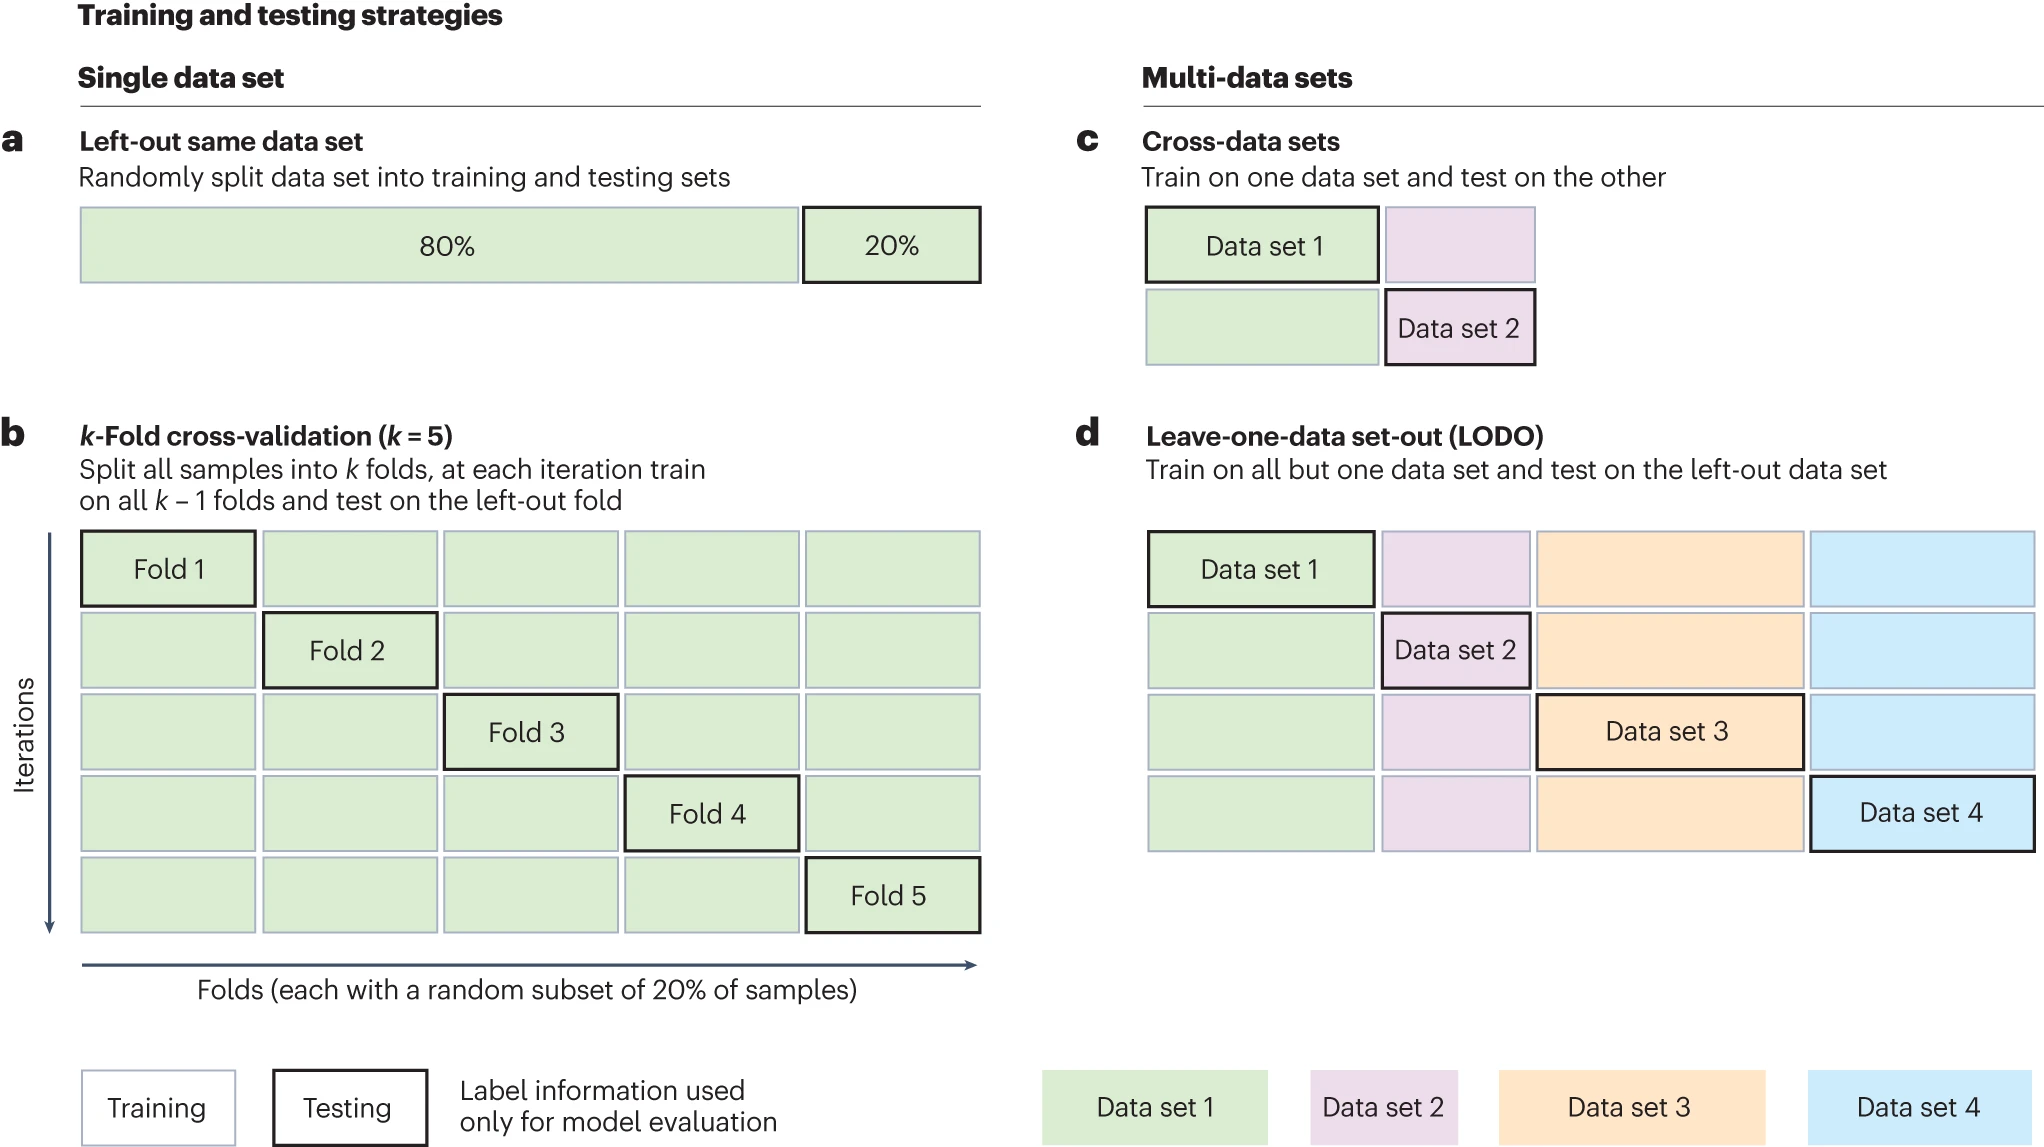

**a,b**, Supervised machine learning training (lighter boxes) and testing (bold boxes) strategies for when a single data set is available using splitting and re-sampling. Splitting one single data set into two subsets (usually with 80% and 20% of the samples, respectively) and using the larger one for model training and the smaller for model testing (panel **a**). k-Fold cross-validation iterates the previous splitting strategy k times (usually k = 5 or 10). It is also possible to repeat the k-fold cross-validation multiple times with random choices of the samples belonging to the folds. This strategy improves the validation power of the left-out same data set as it is less dependent on the choice of the samples in the testing set (panel **b**).

**c,d**, Multi-data sets training and testing strategies using cross-data set or leave-one-data set-out (LODO) approaches. A cross-data set approach exploits one data set for training the model and the other independent data set for testing it. This is a better estimation of the generalization power of the model compared with single data set evaluations as it directly tests the performances of a different data set with potentially unavoidable differences (panel **c**). When more than two data sets are available, the LODO approach exploits n – 1 data sets for the training phase and uses the left-out data set for testing, repeating for all data sets. It combines the improved generalizability of the model when trained on distinct data sets with potentially different underlying differences with the comprehensive evaluation performed on multiple left-out data sets (panel **d**).

When doing a k-Fold cross-validation with k==n (n is the number of samples) it is called leave-one-out (LOO). Its the best k to use when you have endless computational power, as it uses all but one sample in each trainning iteration and tests the reults on all samples, one at a time.

Source:\
"Machine learning for microbiologists" by Asnicar et al.,\
Nature Reviews Microbiology https://doi.org/10.1038/s41579-023-00984-1.

Split the data into train and test sets using sklean
- it is customary to use 80% of the data for training
- notice the shape of the data and included features
- make sure to set a random state, otherwise your results will not be reproducible
- as a temporary step, set shuffle=False

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
X_test

In [ ]:
y_test

What precentage of your train labels are positive? and of your test labels? is that okay?

**Stratification** is a technique used when dealing with imbalanced data. It ensures that the distribution of classes in the train and test sets is representative of the overall data. As our label classes are highly imbalanced, only 1% have covid, use label stratification.

- its an argument of the previous function
- to use it you need to set shuffle=True

Has it improved?

Train a XGBClassifier

As you can see, the model has many hyperparameters you can tune. As promised, we will explore this in a later section of this tutorial.

Use the model to predict the labels of the test set

In [ ]:
y_pred

Instead of looking at the prediced class, one can look at the probability of said prediction. This means that even though two samples got the same predicted label, the model had different confidence in these predictions

In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
# a numpy array of shape (n_samples, n_classes) 
# with the probability of each data example being of a given class
y_pred_proba

In [ ]:
# in the binary case, the predict probability of class 1 equals one minus the predicted probability of class 0, 
# so using just one of them is enough
y_pred_proba = y_pred_proba[:, 1]

In [ ]:
y_pred_proba

This tutorial focuses on classification models and methods to evaluate them. It is important to note that regression models also exist and require different evaluation techniques, as outlined in the pre-diabetes exercise.

## Model evaluation

**Model evaluation** is the process in which we measure how well the model performs on data it has never encountered during training. This evaluation provides a more realistic measure of your model's capabilities.

Compute the accuracy of the model

We know only 1% of the people actually had covid, in this case the simplest of models could predict everybody are healthy and obtain a 99% accuracy. So for imbalanced data sets (which is usually the case) there are better evaluation metrics.

**Area under the receiver operating characteristic curve** \
The area under the receiver operating characteristic curve, often denoted as AUC_ROC, is a performance metric used to evaluate the ability of a classification model to distinguish between the positive and negative classes. The ROC curve is a graphical representation that illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) across different threshold values.

The key components are defined as follows:

\begin{align*}
\text{True Positive Rate (Sensitivity):} \quad & \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} \\
\text{False Positive Rate (1 - Specificity):} \quad & \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
\end{align*}

The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold values. The AUC_ROC quantifies the overall performance of the model by calculating the area under this curve. The AUC value ranges from 0 to 1, where:

- A model with an AUC of 1 indicates perfect discrimination, achieving a true positive rate of 1 and a false positive rate of 0 across all thresholds.
- A model with an AUC of 0.5 represents random chance, as the ROC curve coincides with the diagonal line connecting the points (0, 0) and (1, 1). This is equivalent to a model that cannot distinguish between the positive and negative classes.

Write a function that gets the y_test and y_pred_proba and plots the ROC curve

Check yourself using the sklearn function, if your plot looks different go back and fix it\
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

Class imbalance can be corrected using sample weights. In this settings the samples of the rare class are given more weight during training. There are two ways of doing so in XGB:

1. In the fit function using sample_weight
2. In the model instance using scale_pos_weight.\
A typical value to consider: sum(negative instances) / sum(positive instances)

The sample_weight parameter allows you to specify a different weight for each training example.\
The scale_pos_weight parameter lets you provide a weight for an entire class of examples ("positive" class).

Implement the second option

Has the model preformence improved?

Try a few other weight values

Lets go back to working with our un-weighted model

**Area Under the Precision-Recall Curve**

In addition to ROC, Precision and Recall are two important metrics that provide insights into the performance of a model, especially when dealing with imbalanced datasets.

**Precision**, also known as Positive Predictive Value, measures the accuracy of the positive predictions made by the model. It answers the question: "Of all instances predicted as positive, how many are actually positive?".

\begin{align*}
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\end{align*}

A high precision indicates that the model is making accurate positive predictions, minimizing false positives.

**Recall**, also known as Sensitivity or True Positive Rate, measures the ability of the model to capture all positive instances. It answers the question: "Of all actual positive instances, how many did the model correctly predict?"

\begin{align*}
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{align*}

A high recall indicates that the model is effective at capturing most of the positive instances, minimizing false negatives.

There is often a trade-off between precision and recall. Increasing one may lead to a decrease in the other, and vice versa. This trade-off is controlled by adjusting the classification threshold.

A model with high precision but low recall may be cautious in predicting positive instances, making fewer positive predictions but with high accuracy. On the other hand, a model with high recall but low precision may be more inclusive in predicting positive instances, capturing more positive cases but with lower accuracy.

A real world example could be cancer diagnosis and treatment. At the diagnosis stage, you would want high recall and not miss any case. Before starting chemotherapy you would want high precision, to make sure the rough treatment is necessary.

Similar to the AUC_ROC, the Area Under the Precision-Recall Curve (AUC_PR) provides a single scalar value summarizing the model's performance across different precision-recall trade-offs. A high AUC_PR indicates a model that achieves high precision and high recall across a range of thresholds.

Write a function that gets the y_test and y_pred_proba and plots the PR curve

Check yourself using the sklearn function, if your plot looks different go back and fix it\
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve

In the case of PR curve, its rarely relaistic to aspire to AUC of 1, and one needs to consider what is the baseline he is trying to beat. In the COVID case, at an unknown recall (as the actual number of cases is unknown), the overall precision of all tests in Israel was 4.6% at the time our model was conceived. The model substantially outperforms this precision at any recall threshold up to 50%. Thus, our model can complement the identification of individuals at high risk for a positive test, who can be further isolated prior to obtaining the test.

**Calibration curve**
Illustrates the relationship between predicted probabilities generated by a classification model and the actual probability of an outcome. It is a valuable tool for assessing the reliability of a model's predicted probabilities.

Here are the key components and interpretations of a calibration curve:

**Mean Predicted Probability**: This mean is calculated based on the predicted probabilities assigned by the model for a set of instances or observations with similar values - i.e. bin, the x-axis.

**Fraction of Positives**: The fraction of instances that actually belong to the positive class within the same set (bin) of instances, the y-axis.

The diagonal dashed line (usually shown as a diagonal from the bottom-left to the top-right) represents perfect calibration. If a model is perfectly calibrated, the predicted probabilities would match the true fraction of positives for all probability levels. Deviation from the perfect calibration line indicates how well the model's predicted probabilities align with the true outcomes.

If the calibration curve deviates from the perfect calibration line, it suggests that the model may be overconfident or underconfident in its predictions. Overconfidence occurs when predicted probabilities are higher than the observed fraction of positives, and underconfidence occurs when predicted probabilities are lower than the observed fraction of positives.

Calibration curves are useful for evaluating the reliability of predicted probabilities, especially in scenarios where accurate probability estimates are crucial, such as in medical diagnosis or risk assessment. They provide insights into the calibration performance of a model, helping practitioners make informed decisions about the model's trustworthiness.

Write a function that gets the y_test and y_pred_proba and plots the calibration curve. \
Start by binning the y_pred_proba to five bins.

In this specific case, it is okay if the curve starts to act crazy after 0.7

Check yourself using the sklearn function, if your plot looks different go back and fix it\
https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html#sklearn.calibration.calibration_curve

## Hyperparameters

This section of the tutorial is based on: \
https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

Model **hyperparameters** are external configurations that are set prior to the training process and cannot be learned from the data. They play a crucial role in the performance and behavior of a machine learning model. Unlike parameters, which are learned from the data during training, hyperparameters are set by the practitioner based on their understanding of the problem, the data, and the specific algorithm being used.

For Gradient Boosting Decision Trees, there are several hyperparameters that can be tuned to optimize the model's performance. Some of the key hyperparameters include:

**eta** [default=0.3, alias: learning_rate]\
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.\
range: [0,1]

**gamma** [default=0, alias: min_split_loss]\
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.\
range: [0,∞]

**max_depth** [default=6]\
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.\
range: [0,∞]

**min_child_weight** [default=1]\
Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.\
range: [0,∞]

**subsample** [default=1]\
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.\
range: (0,1]

**colsample_bytree, colsample_bylevel, colsample_bynode** [default=1]\
This is a family of parameters for subsampling of columns.\
**colsample_bytree** is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.\
**colsample_bylevel** is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.\
**colsample_bynode** is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.\
All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.\
colsample_by* parameters work cumulatively. For instance, the combination {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5} with 64 features will leave 8 features to choose from at each split.\

**lambda** [default=1, alias: reg_lambda]\
L2 regularization term on weights. Increasing this value will make model more conservative.\
range: [0, ]

**alpha** [default=0, alias: reg_alpha]\
L1 regularization term on weights. Increasing this value will make model more conservative.\
range: [0, ]

**max_leaves** [default=0]\
Maximum number of nodes to be added. Not used by exact tree method.

Tuning these hyperparameters is a crucial step in optimizing the performance of a model for a specific task. This tuning process is often performed using techniques like grid search or randomized search, where different combinations of hyperparameter values are evaluated to find the optimal configuration. The choice of hyperparameters depends on the characteristics of the data and the specific goals of the modeling task.

Train a new model while tuning the hyperparameters\
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* Use GridSearchCV on the following param_grid
* The scoring function should be 'roc_auc'
* Read about the refit argument
* Use 4 fold cross validation, stratified, shuffled and reproducible as before, on the ENTIRE dataset

In [ ]:
param_grid = {'colsample_bytree': [0.7, 0.8], 
              'learning_rate': [0.005, 0.01], 
              'max_depth': [4, 6],
              'min_child_weight': [5, 10], 
              'n_estimators': [500, 1000, 1500], 
              'subsample': [0.7, 0.8]}

What are the chosen hyperparameters?

What is the test score?\
hint: look at the cv_results_

Wondering why there are 96 scores? \
For each combination of hyperparameters in param_grid, the model is trained and evaluated 4 times (once for each fold). If you have 4 folds and 24 unique combinations of hyperparameter values, you will end up with 96 total results.

Is it better than the model with the default parameters?

## External data set

One of the important parts of model evaluation is to prevent **overfitting**. Overfitting occurs when a model learns to memorize the training data but fails to generalize to new data.

You shared the model with a colleague and he returned the predictions on his own data

In [ ]:
external = pd.read_csv('predictions.csv', index_col=0)

In [ ]:
external

How did the model do on his data?

Does it depend on 'days2test'? (a column in the df that describes how many days before the the PCR test the questionnaire was filled)

## Summary

In this tutorial, you gained insights into Gradient Boosting Decision Trees, understanding their functionality and distinguishing features from Random Forests. The emphasis was on creating models that not only perform well on training data but also generalize effectively to new datasets.

A crucial lesson underscored the importance of meticulous dataset examination, addressing issues like data format discrepancies that could introduce bias into the model. Three distinct train-test strategies were explored: the basic 80-20 split, K-fold cross-validation, and cross-data sets validation. Stratification emerged as a key consideration, ensuring the dataset mirrors the challenges the model is likely to encounter in real-world scenarios.

The tutorial delved into model evaluation techniques, including ROC, PR, and calibration, shedding light on the limitations of relying solely on accuracy, which is often inherently biased. Hyperparameter tuning, a perpetual challenge, was discussed, highlighting the unique challenges posed by tree-based methods.

As you continue your journey, remember the critical principles of thoughtful dataset analysis, effective model evaluation, and the subtle nature of hyperparameter tuning, acknowledging the strengths and weaknesses inherent in different modeling approaches.